## SETUP

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()
######## need to find the chained assignment!!!
pd.set_option('mode.chained_assignment', None)

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file, param):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV'][param]
        return config
config = get_config(config_file, 'combine')



user = 'martinscience'
# HOME
home = '/Users/mahtin'
home = '/Users/martinscience'

# get the code
import sys
sys.path.append('../scripts')
from codeCNV.plot import plot_genomic, plot_snp2, plot_snp, plot_2d, plot_3d
from script_utils import show_output


# user = 'mahtin'
HOME = f"/Users/{user}"
wes_path = f"{HOME}/Dropbox/Icke/Work/somVar/AMLMono7/WESData"
path = f"{wes_path}"
!ls {path}

AMLPresi.pptx         P483                  PGDC
AML_relapse.csv       P559                  Pmerge
AML_relapse.xlsx      P615                  SNPplots.ipynb
AML_relapse1.xlsx     P625                  WES CNV Analysis.xlsx
CNVplots              P665                  filter1.csv
CNVraw                P685                  filter1GDC.csv
P12                   P778                  samples.csv


### load da code

In [2]:
def center_data(cluster_df):
    '''
    get the center_df containing only points belonging to both Centercores
    '''
    
    cols = ['log2ratio', 'log2ratiomean', 'absVAF', 'absVAFmean']

    # get the center_df with points belonging to both Centercores
    center_df = cluster_df.query('covCentercore + snpCentercore == 2').copy()
    # get the mean and std for relevant columns
    center_params = center_df[cols + ['VAF']].agg(['mean', 'std']).T
    # get the cnv_df with at least one CNVcore per point
    cnv_df = cluster_df.query('snpCNVcore > 0').copy()
    
    for col in cols:
        center_df.loc[:, col] = center_df[col] - center_params.loc[col, 'mean']
        cnv_df.loc[:, col] = cnv_df[col] - center_params.loc[col, 'mean']
        
    cnv_df.loc[:, 'VAF'] = cnv_df['VAF'] + 0.5 - center_params.loc['VAF', 'mean']
    center_df.loc[:, 'VAF'] = center_df['VAF'] + 0.5 - center_params.loc['VAF', 'mean']
    return cnv_df, center_df, center_params

def llh2d(dx, dy, mx=0, my=0, sx=0.5, sy=0.1):
    '''
    compute the density function for a given gaussian
    takes a pd.Series or np.array
    '''   
    # get the fixed term
    s = 2 * np.pi * sx * sy
    return np.exp((((dx - mx) / sx) **2 + ((dy - my) / sy) **2) / -2) / s

# start with a simple dataFrame
import math

def get_gauss_mask(alpha, Nmax):
    '''
    returns the gauss params for the gauss mask
    '''
    
    alpha = min(1,alpha)
    df = pd.DataFrame()
    for n in range(int(Nmax)):
        N = n + 1 
        for i in range(math.ceil((N + 1) / 2)):
            string = "A" * (N - i) + "B" * i
            if string == 'A':
                string = 'LOH'
            absVAF = alpha * np.abs((2 * i) / N - 1)
            log2 = np.log2(2 + alpha * (N - 2)) - 1
            s = pd.Series({'type': string, 'absVAF': absVAF, 'log2ratio': log2})
            df = df.append(s, ignore_index=True)
    return df.query('absVAF !=0 or log2ratio != 0')

def mask2VAF(mask_df):
    '''
    converts the gauss_mask for absVAF into mask for VAF
    '''
    
    df = mask_df.copy()
    df.loc[:, 'VAF-'] = 0.5 - df['absVAF'] / 2
    df.loc[:, 'VAF+'] = 0.5 + df['absVAF'] / 2
    return df.loc[:, ['VAF-','VAF+', 'log2ratio', 'type']]


plt.style.use('seaborn-white')

def plot_gaussian(df, xcol, ycol, 
                  df2=pd.DataFrame(), 
                  Nmax=0,   # maximal expected
                  alpha=1,
                  gauss_params=pd.DataFrame(), # the center_params containing the std
                  logmax=2.5, 
                  std_factor = 1,
                  rings=10, # number of rings for contour
                  figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.scatter(df[xcol], df[ycol], s=.1)
    if len(df2.index):
        _ = ax.scatter(df2[xcol], df2[ycol], s=1, color='red')
    _ = ax.set_xlabel(xcol, fontsize=15)
    _ = ax.set_ylabel(ycol, fontsize=15)
    _ = sns.despine(ax=ax, offset=0)
    _ = ax.spines['left'].set_position('zero')

    
    def get_lims(col):
        if 'log' in col:
            return (-1.5, logmax)
        if 'VAF' in col:
            return (-0.05, 1.05)
    _ = ax.set_xlim(get_lims(xcol))
    _ = ax.set_ylim(get_lims(ycol))
    
    # add gaussian mask
    if Nmax:
        # create the grid
        x = np.linspace(*get_lims(xcol), 500)
        y = np.linspace(*get_lims(ycol), 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        
        # get the std from the params
        sx, sy = gauss_params.loc[[xcol, ycol], 'std']
        print(sx, sy)
        sx *= std_factor
        sy *= std_factor
        gaussians = get_gauss_mask(alpha, Nmax)
        if xcol == 'VAF':
            gaussians = mask2VAF(gaussians)
            for _, row in gaussians.iterrows():
                mx1 = row['VAF-']
                mx2 = row['VAF+']
                my = row['log2ratio']
                Z += llh2d(X,Y, mx1, my, sx, sy) +   llh2d(X,Y, mx2, my, sx, sy)
                ax.text(mx1, my-0.2, row['type'], ha='center')
                ax.text(mx2, my-0.2, row['type'].replace('A', 'G').replace('B', 'A').replace('G', 'B'), ha='center')
        else:
            for _, row in gaussians.iterrows():
                mx = row['absVAF']
                my = row['log2ratio']
                Z += llh2d(X,Y, mx, my, sx, sy)
                ax.text(mx, my-0.2, row['type'], ha='center')
        _ = ax.contour(X,Y,Z, rings, colors='black', alpha=1,linewidths=.4)
    # set the y-spine
    _ = ax.axhline(y=0, color='k')
    _ = ax.axvline(x=0, color='k')
    _ = ax.axvline(x=1, color='k')
    if xcol == 'VAF':
        _ = ax.axvline(x=0.5, c='k',ls="--")

    return fig, ax

log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=1,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=1,
            color='black',
            s=2,
            alpha=.4
        ))

fig_params = dict(
    figsize=(48,10),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)

### make sample_df

In [3]:
projects = [f"P{i}" for i in [483,559,615,625,665,685,778,"merge"]]

def get_sample_name(file):
    sample = os.path.basename(file).split(".")[0]
    name = sample.split('_')[0] + sample.split('_')[1].replace("-B", "")
    return name


sample_df = pd.DataFrame()
for project in projects:
    folder = os.path.join(wes_path, f"{project}/CNV")
    print(f"Looking for filter files in {folder}")
    for folder, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".cluster"):
                sample = file.replace(".cluster", "").replace("_", "")
                s = pd.Series(dict(sample=sample, project=project, file = os.path.join(folder, file)))
                sample_df = sample_df.append(s, ignore_index=True)
sample_df = sample_df.sort_values(['project', 'sample']).loc[:, ['project', 'sample', 'file']]
sample_df

Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P483/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P559/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P615/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P625/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P665/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P685/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/P778/CNV
Looking for filter files in /Users/martinscience/Dropbox/Icke/Work/somVar/AMLMono7/WESData/Pmerge/CNV


,project,sample,file
24,P483,01A,/Users/martinscience/Dropbox/Icke/Work/somVar/...
29,P483,01B,/Users/martinscience/Dropbox/Icke/Work/somVar/...
16,P483,02A,/Users/martinscience/Dropbox/Icke/Work/somVar/...
7,P483,02B,/Users/martinscience/Dropbox/Icke/Work/somVar/...
8,P483,03A,/Users/martinscience/Dropbox/Icke/Work/somVar/...
...,...,...,...
121,Pmerge,54B,/Users/martinscience/Dropbox/Icke/Work/somVar/...
119,Pmerge,55A,/Users/martinscience/Dropbox/Icke/Work/somVar/...
130,Pmerge,55B,/Users/martinscience/Dropbox/Icke/Work/somVar/...
134,Pmerge,57A,/Users/martinscience/Dropbox/Icke/Work/somVar/...


In [4]:
def get_file(sample):
    sample = sample.replace("_", "")
    return sample_df.query('sample == @sample').iloc[0,2]

## test samples

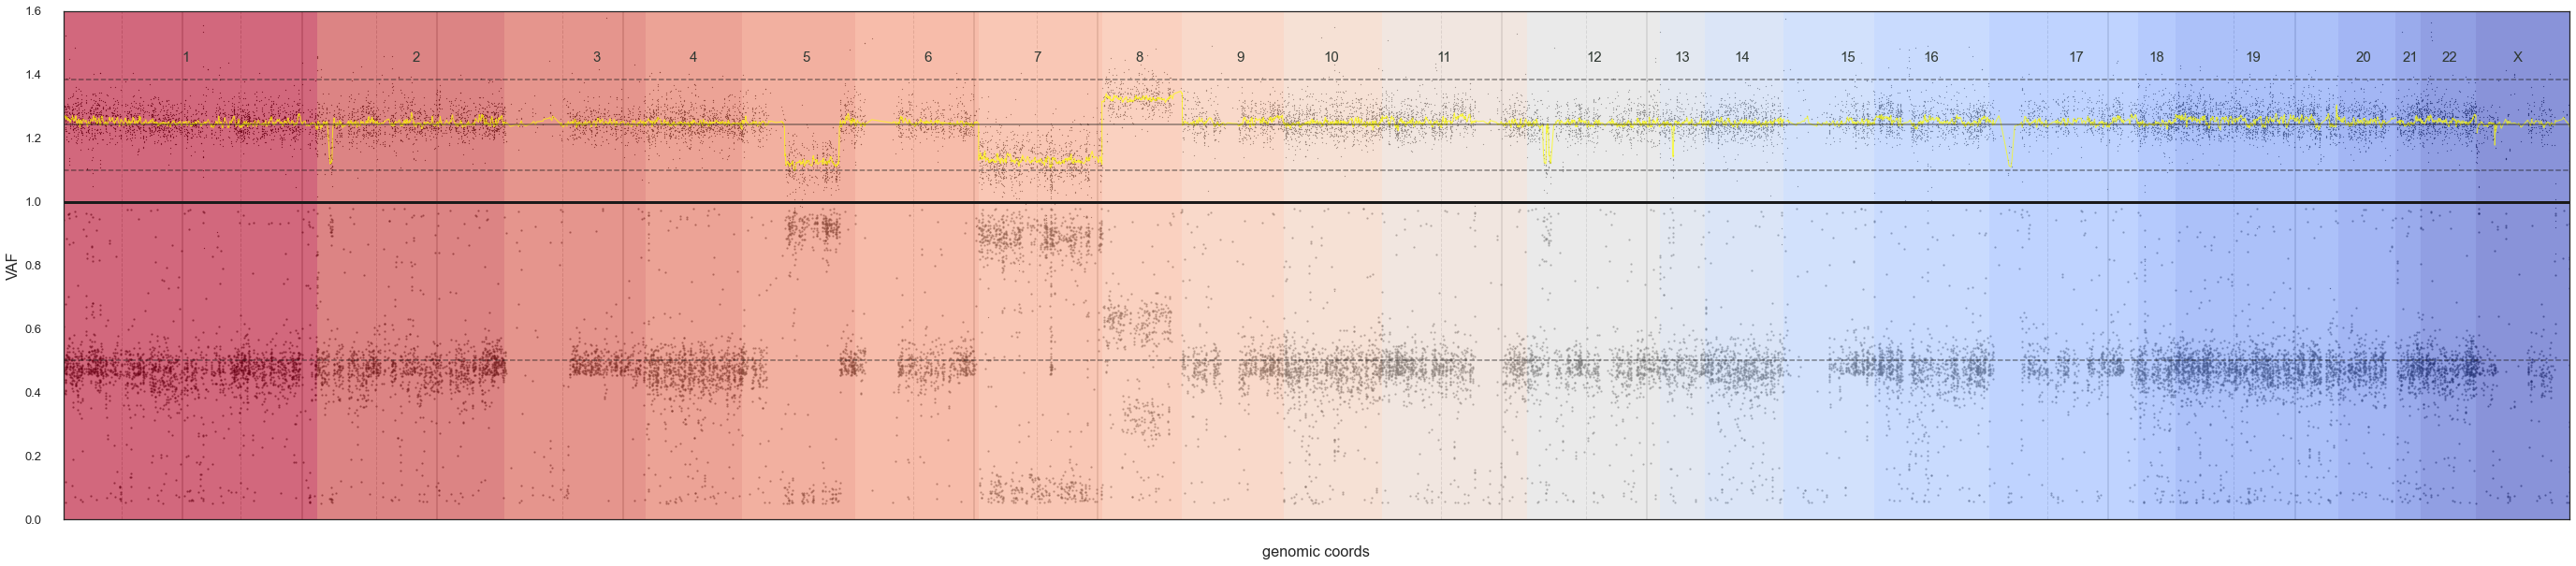

In [94]:
sample = "04A"
cluster_df = pd.read_csv(get_file(sample), sep='\t')
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
cnv_df, center_df, center_params = center_data(cluster_df)
_ = plot_snp2(cluster_df, snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='', **fig_params)

0.11664148829812851 0.06013868241712256


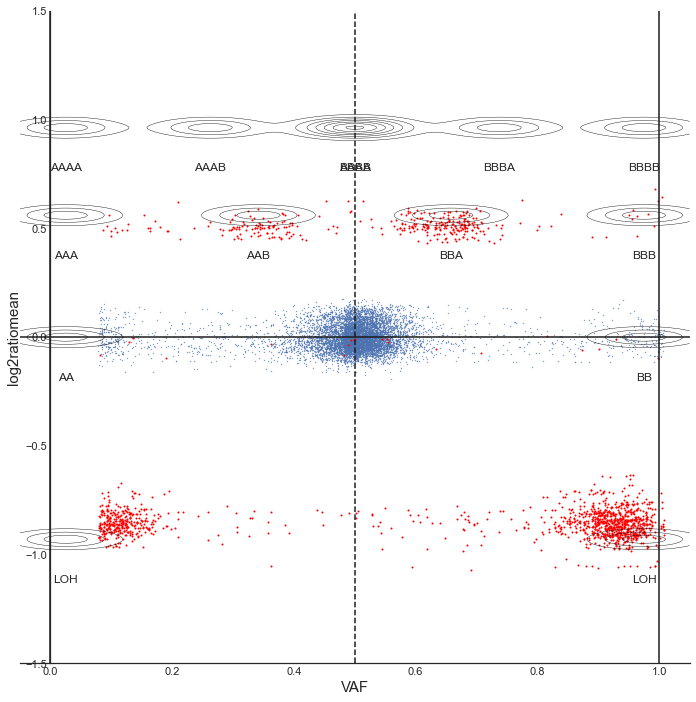

In [95]:
cnv_df, center_df, center_params = center_data(cluster_df)
xcol = 'VAF'
ycol = 'log2ratiomean'
fig, ax = plot_gaussian(
    center_df,
    df2=cnv_df,
    xcol=xcol, 
    ycol=ycol, 
    Nmax=4, 
    rings=8,
    logmax=1.5,
    alpha=.95, 
    std_factor=.5,
    gauss_params=center_params
)